# EDA for energy anomaly detection data
Data sourced from Kaggle competition: https://www.kaggle.com/competitions/energy-anomaly-detection

In [6]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


## Data structures

In [12]:
print(df_train.anomaly.unique())

[0 1]


In [4]:
df_train = pd.read_csv("../DATA/energy-anomaly-detection/train_features.csv")
df_weather = pd.read_csv("../DATA/energy-anomaly-detection/train.csv")
df_md = pd.read_csv("../DATA/energy-anomaly-detection/train.csv")

print(df_train.dtypes)

building_id                        int64
timestamp                            str
meter_reading                    float64
anomaly                            int64
site_id                            int64
primary_use                          str
square_feet                        int64
year_built                         int64
floor_count                        int64
air_temperature                  float64
cloud_coverage                     int64
dew_temperature                  float64
precip_depth_1_hr                  int64
sea_level_pressure               float64
wind_direction                     int64
wind_speed                       float64
air_temperature_mean_lag7        float64
air_temperature_max_lag7         float64
air_temperature_min_lag7         float64
air_temperature_std_lag7         float64
air_temperature_mean_lag73       float64
air_temperature_max_lag73        float64
air_temperature_min_lag73        float64
air_temperature_std_lag73        float64
hour            

## XGBoost

In [5]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('encoder', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,verbose,0
,cols,None
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


In [7]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values

In [13]:
opt.fit(df_train.drop('anomaly', axis=1), df_train['anomaly'])

,estimator,"Pipeline(step...=None, ...))])"
,search_spaces,"{'clf__colsample_bylevel': Real(low=0.5,...m='normalize'), 'clf__colsample_bynode': Real(low=0.5,...m='normalize'), 'clf__colsample_bytree': Real(low=0.5,...m='normalize'), 'clf__gamma': Real(low=0.0,...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,10
,scoring,'roc_auc'
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

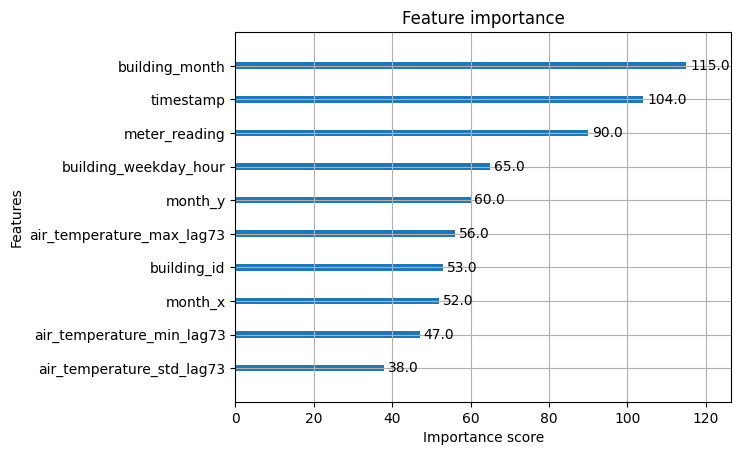

In [16]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model,max_num_features=10)

## LSTM